In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# DeepTrack 2.0 - Introduction

This tutorial gives an overview of how to use DeepTrack 2.0.

### What is DeepTrack 2.0?

DeepTrack 2.0 is a software that provides a comprehensive framework for digital microscopy enhanced by deep learning. Possible applications include particle identification, particle tracking, image segmentation, and cell counting. This tutorial focuses on the simple task to track a particle.

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

u = dt.units

## 1. Generate images

In order to train and validate deep-learning models to be used in digital microcopy, we need to generate synthetic images. For example, these images may be like the output of a digital video micoscopy experiment, where we want to track some particles.

In DeepTrack 2.0, any image can be viewed as a series of **features** applied in a sequence. Each feature takes an input image and updates it according to an **update rule**. For example, a feature can add a particle, introduce some noise, or image something through an optical device.

### Features and properties

In DeepTrack 2.0, these features are classes implementing the class `Feature` (see also [features_example](../examples/features_example.ipynb)). The way a feature updates an image is determined by the values passed to the class constructor. These inputs are converted to **properties** (see also [properties_example](../examples/properties_example.ipynb)). For example, a property could be the position of a particle. 

For example, the code below creates a feature: a point particle implemented by the class `PointParticle` with properties `position=(0, 0)`, and `intensity=1`. We use `u.pixel` to denote the unit of the property. Most of the time (such as here) this can be omitted.

In [3]:
particle = dt.PointParticle(
    position=(0, 0) * u.pixel,
    intensity=1
)

The above feature is completely deterministic so that the particle will always be at position (0, 0). For machine learning, it may be more useful to add a particle at a random position. This can be done by passing a lambda function that returns a pair of random numbers to the property `position`.

In [4]:
IMAGE_SIZE = 64

particle = dt.PointParticle(
    position=lambda: np.random.rand(2) * IMAGE_SIZE * u.pixel,
    intensity=1
)

A point particle on its own does not make much sense when thinking of actual experiments. In order to get a more realistic image, we need to define also the optical device through which it is viewed. In DeepTrack 2.0, optical devices are features that convolve the input image with a pupil function. Here, we will use a fluorescence microscope `fluorescence_microscope`, which is implemented by the feature `Fluorescence` (see also [optics_example](../examples/optics_example.ipynb)). 

By calling the fluorescence microscope `fluorescence_microscope` with the point particle `particle`, we create a new feature which resolves the image of the particle as seen through the fluorescence microscope.

In [5]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.8,
    wavelength=680 * u.nm,
    magnification=10,
    resolution=1 * u.micrometer,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE)
)

imaged_particle = fluorescence_microscope(particle)

We can finally create the image of the particle by calling the feature `imaged_particle()` and plot it.

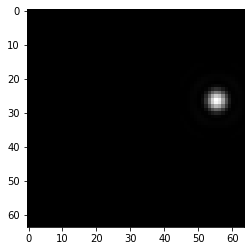

In [6]:
output_image = imaged_particle()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

You might have noticed that, even though the position of the particle is random, it doesn't change if you refresh the cell. This is because the value of the particle position is stored as a property of the particle, useful for example to know the ground truth value of the particle position to train a deep-learning model.

If you want the particle position to change each time you refresh the cell, you need to call the method `imaged_particle.update()` before resolving the image.

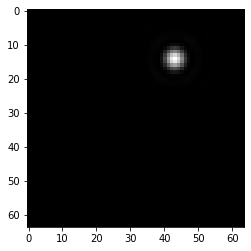

In [7]:
imaged_particle.update()
output_image = imaged_particle()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

### Adding more features

Features can be combined (see also [features_example](../examples/features_example.ipynb)) using overloaded operators (>>, &, ^). Here exemplify the and operator (&) and the xor operator (^).

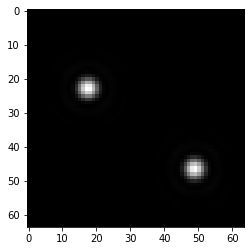

In [8]:
# The & operator

particle_1 = dt.PointParticle(
    position=lambda: np.random.rand(2) * IMAGE_SIZE,
    intensity=1
)

particle_2 = dt.PointParticle(
    position=lambda: np.random.rand(2) * IMAGE_SIZE,
    intensity=1
)

two_particles = particle_1 & particle_2

# imaged_two_particles is a new feature that first resolves particle_1 and then particle_2, then images it
imaged_two_particles = fluorescence_microscope(two_particles)

output_image = imaged_two_particles()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

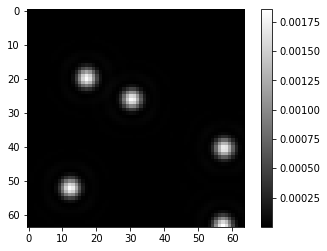

In [9]:
# # The ^ operator

particle = dt.PointParticle(
    position=lambda: (np.random.rand(2) * IMAGE_SIZE),
    intensity=1
)

five_particles = particle^5

# five_particles is a feature that resolves five instances of particle, then images it
imaged_five_particles = fluorescence_microscope(five_particles)


output_image = imaged_five_particles.update()()


plt.imshow(np.squeeze(output_image), cmap='gray')
plt.colorbar()
plt.show()


### Adding noise

To make the image more realistic, we can now add some noise (see also [noises_example](../examples/noises_example.ipynb)).

Note that we set the background property of Poisson to be equal to the value we add by setting `background=offset.value`. This is how you make features dependent on eachother! 

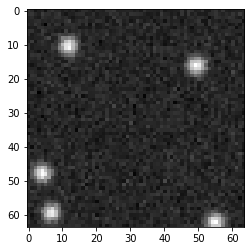

In [10]:
particle_plus_background = fluorescence_microscope(particle^5) + (lambda: np.random.rand() * 0.1)


imaged_noisy_particles = particle_plus_background >> dt.Poisson(
    snr=5, 
    background=dt.Median(particle_plus_background)
)

output_image = imaged_noisy_particles.update()()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

## 2. Retrieve information about the image

To train a supervised machine-learning model, labelled images are needed. When a feature is resolved, it automatically stores the properties of all features used to create the image. This allows us to extract information about the image, for example, in order to use them to train machine-learning models. We show two ways of getting a list of positions of all particles in the image.

Here, we extract the position of all the particles and plot them as red crosses on the generated image.

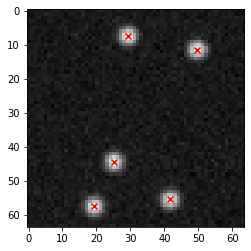

In [11]:
def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = [property_dict["position"] for property_dict in image.properties if "position" in property_dict]
    # Alternatively
    positions = image.get_property("position", get_one=False)
    return np.array(positions)


imaged_noisy_particles.update()
output_image = imaged_noisy_particles()

positions = get_positions(output_image)

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(positions[:, 1], positions[:, 0], c="r", marker="x")
plt.show()

## 3. Wrap features in generators

Generators are ways to continuously resolve new images, and are the prefered interface to machine learning models. The default generator is defined in the module `generators` (see also [generators_example](../examples/generators_example.ipynb)). We can also optionally pass a label function that will be called on every image, in this case we will use the function `get_positions` that we have implemented above.

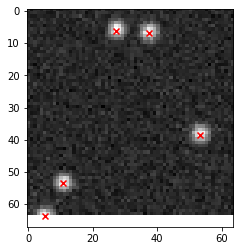

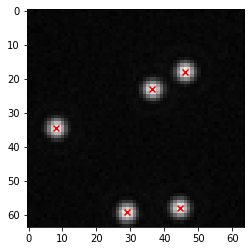

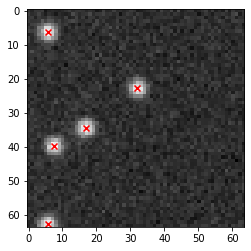

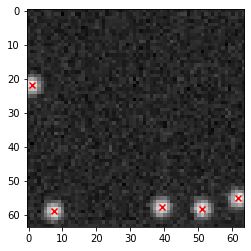

In [12]:
generator = dt.generators.Generator().generate(imaged_noisy_particles, label_function=get_positions)

for _ in range(4):
    # Outputs shape (1, height, width, 1) to conform with expected model input
    next_image, positions = next(generator)
    plt.imshow(np.squeeze(next_image), cmap='gray')
    plt.scatter(positions[0, :, 1], positions[0, :, 0], c='r', marker='x')
    plt.show()

There's also `ContinuousGenerator` which often outperforms `Generator` (in terms of time to train). We will show this later in the tutorial.

## 4. Training the model

We are finally ready to create a deep-learning model to track the particles.
We will use a convolutional neural network implemented by the function `convolutional` (see also [models_example](../examples/models_example.ipynb)) to track point particles (`particle`) imaged through a fluorescence microscope (`fluorescence_microscope`) with some noise (`offset` and `poisson_noise`). We will furthermore use the feature `NormalizeMinMax` to normalize the dynamic range of the images btween 0 and 1.

This model is designed to track a single particle with a high accuracy. It is not well suited for the task of multi-particle tracking.

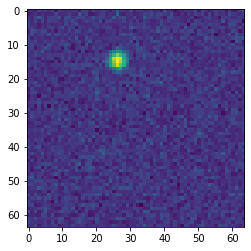

In [19]:
from deeptrack.models import convolutional
from deeptrack.math import NormalizeMinMax

# DEFINE LABEL FUNCTION
def get_position(image):
    return image.get_property("position") / IMAGE_SIZE
        
# DEFINE MODEL
model = convolutional(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), number_of_outputs=2)

# DEFINE TRAINING SET
particle_plus_background = fluorescence_microscope(particle) + (lambda: np.random.rand() * 0.1)


imaged_noisy_particles = particle_plus_background >> dt.Poisson(
    snr=5, 
    background=dt.Median(particle_plus_background)
)

training_set = (imaged_noisy_particles - dt.Min(imaged_noisy_particles)) / dt.PeakToPeak(imaged_noisy_particles)

imaged_noisy_particles.plot()

To train the network, we use `ContinuousGenerator`. The syntax is similar to a standard `Generator`, but with some key differences. Mainly, we need to define `min_data_size`, and `max_data_size`. These refer to the amount of data the generator will create before training, and how much data it will store at any one point. `min_data_size` should be set to a few times the batch size (higher is often better, but also slower), while `max_data_size` is mainly limited by the amount of memory on your computer!

We recommend using `ContinuousGenerator` over `Generator` for training in most cases, unless the data generation is very quick or you're loading an experimental dataset. 

In [20]:
generator = dt.generators.ContinuousGenerator(
    training_set,
    get_position,
    batch_size=32,
    min_data_size=256,
    max_data_size=512
)

Now we train the model. Note that we use the `with` statement. This is only needed for a `ContinuousGenerator`, not a standard `Generator`. Be patient, this might take some time (several minutes).

In [21]:
# TRAIN TRACKER
with generator:
    model.fit(generator, epochs=400)

Generating 291 / 256 samples before starting training
Epoch 1/400
9/9 [==============================] - 1s 6ms/step - loss: 0.3695
Epoch 2/400
9/9 [==============================] - 0s 6ms/step - loss: 0.2665
Epoch 3/400
9/9 [==============================] - 0s 6ms/step - loss: 0.1705
Epoch 4/400
9/9 [==============================] - 0s 6ms/step - loss: 0.1224
Epoch 5/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0855
Epoch 6/400
9/9 [==============================] - 0s 7ms/step - loss: 0.0631
Epoch 7/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0569
Epoch 8/400
9/9 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 9/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0499
Epoch 10/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0504
Epoch 11/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0332
Epoch 12/400
9/9 [==============================] - 0s 9ms/step - loss: 0.0299
Epoch 1

9/9 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 105/400
9/9 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 106/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 107/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 108/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 109/400
9/9 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 110/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 111/400
9/9 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 112/400
9/9 [==============================] - 0s 7ms/step - loss: 0.0114
Epoch 113/400
9/9 [==============================] - 0s 7ms/step - loss: 0.0107
Epoch 114/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0129
Epoch 115/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 116/400
9/9 [==============================] - 0

9/9 [==============================] - 0s 7ms/step - loss: 0.0107
Epoch 207/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0100
Epoch 208/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 209/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 210/400
9/9 [==============================] - 0s 7ms/step - loss: 0.0072
Epoch 211/400
9/9 [==============================] - 0s 7ms/step - loss: 0.0088
Epoch 212/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 213/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0082
Epoch 214/400
9/9 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 215/400
9/9 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 216/400
9/9 [==============================] - 0s 7ms/step - loss: 0.0086
Epoch 217/400
9/9 [==============================] - 0s 7ms/step - loss: 0.0073
Epoch 218/400
9/9 [==============================] - 0

9/9 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 309/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 310/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 311/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 312/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 313/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 314/400
9/9 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 315/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 316/400
9/9 [==============================] - 0s 5ms/step - loss: 0.0071
Epoch 317/400
9/9 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 318/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 319/400
9/9 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 320/400
9/9 [==============================] - 0

Finally, we test the trained model on some newly generated images. We can extract a batch from the generator directly

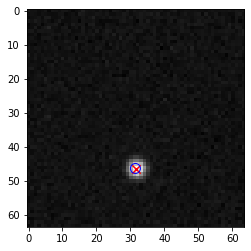

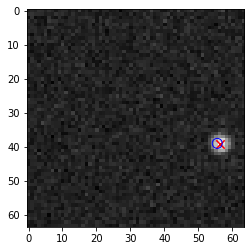

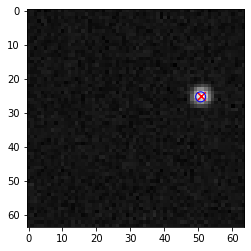

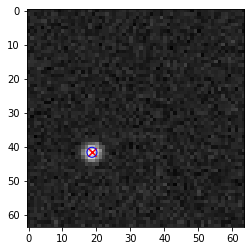

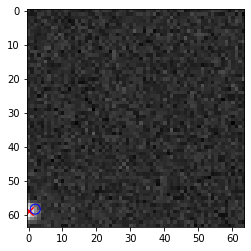

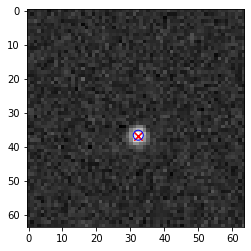

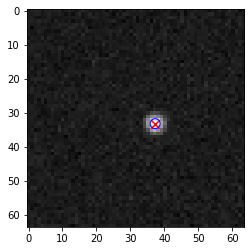

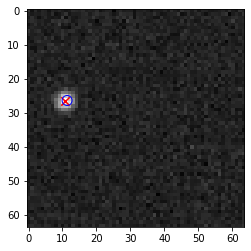

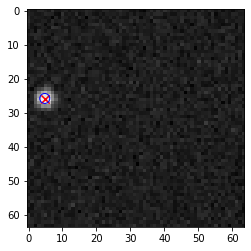

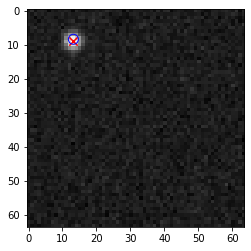

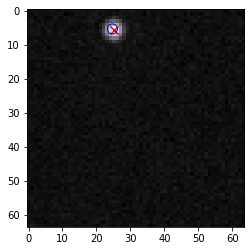

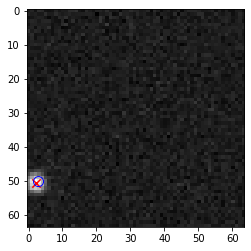

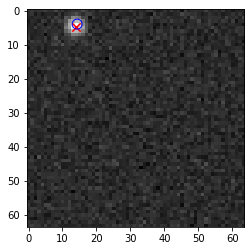

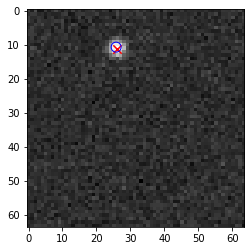

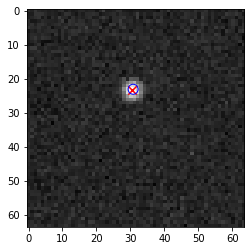

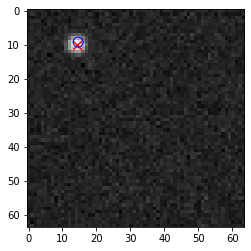

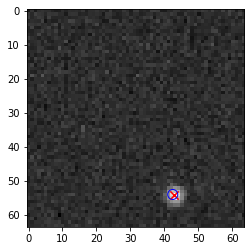

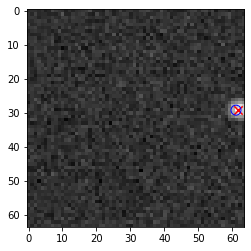

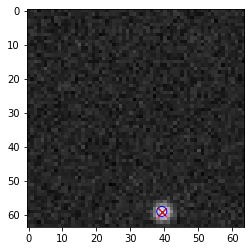

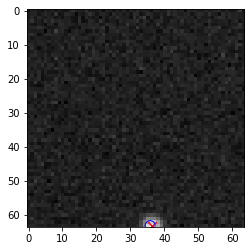

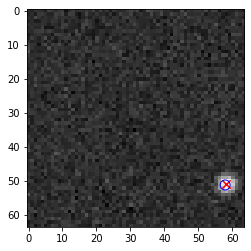

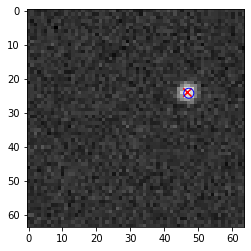

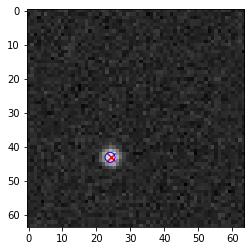

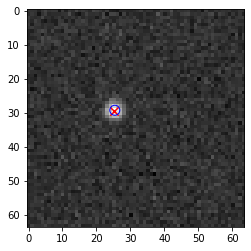

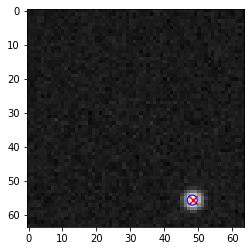

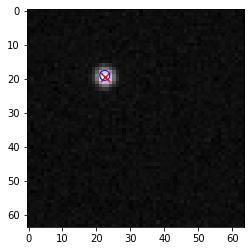

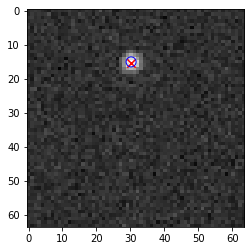

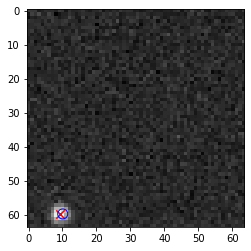

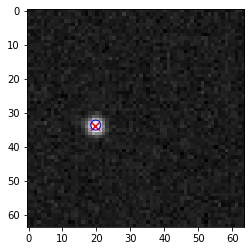

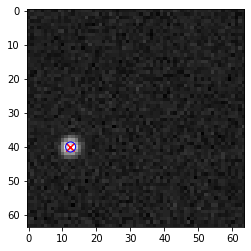

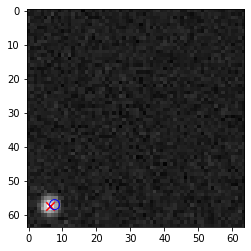

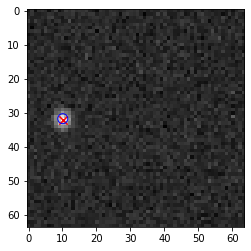

In [22]:
generator.on_epoch_end()

images, real_positions = generator[0]

measured_positions = model.predict(images)



for i in range(images.shape[0]):
    
    image = np.squeeze(images[i])
    
    measured_position_x = measured_positions[i, 1] * IMAGE_SIZE
    measured_position_y = measured_positions[i, 0] * IMAGE_SIZE

    real_position_x = real_positions[i, 1] * IMAGE_SIZE
    real_position_y = real_positions[i, 0] * IMAGE_SIZE

    plt.imshow(image, cmap='gray')
    plt.scatter(real_position_x, real_position_y, s=70, c='r', marker='x')
    plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='b')
    plt.show()